In [1]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
import os.path
from utils import *
from run_simulations import *
from agents import *

%matplotlib notebook
%reload_ext autoreload
%autoreload 2



In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

# import seaborn as sns
# sns.set_style("white")
# sns.set_context("talk")

# color_names = [
#     "windows blue",
#     "red",
#     "amber",
#     "faded green",
#     "dusty purple",
#     "orange"
#     ]

# colors = sns.xkcd_palette(color_names)
# cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
# save_figures = True

In [3]:
world = ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 40], nblockmax=100)
# world, ntrials = make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
agent = ValueAccumulationAgent(gamma=0.1, beta=10)
# agent = EGreedyQLearningAgent(gamma=0.3, eps=0.1)
exp = Experiment(agent, world)
exp.run()  

choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='none')
arr = choicelst[0]
get_num_rewards_trailing_block(world, agent)

array([ 5,  2, 35,  2,  6, 15,  9,  1,  3, 21,  9, 15,  4,  3,  5,  1,  2,
       12,  6,  7, 18,  1,  6,  1, 16,  1,  1, 14,  4, 16, 17, 10,  1, 14,
       13,  5, 10,  6, 16,  4,  5,  1, 10, 15,  2,  4,  1, 28,  7, 28,  1,
        9,  1, 11, 15, 15,  3, 20,  8,  3,  1,  3,  1,  1,  2,  6,  6,  1,
       13,  1, 11,  3,  7,  1,  5,  4, 16, 22,  5,  1,  1,  2,  2,  9, 11,
        6,  8, 15,  8,  3,  1, 21,  5,  4, 31,  9, 13,  6,  9,  3])

<IPython.core.display.Javascript object>


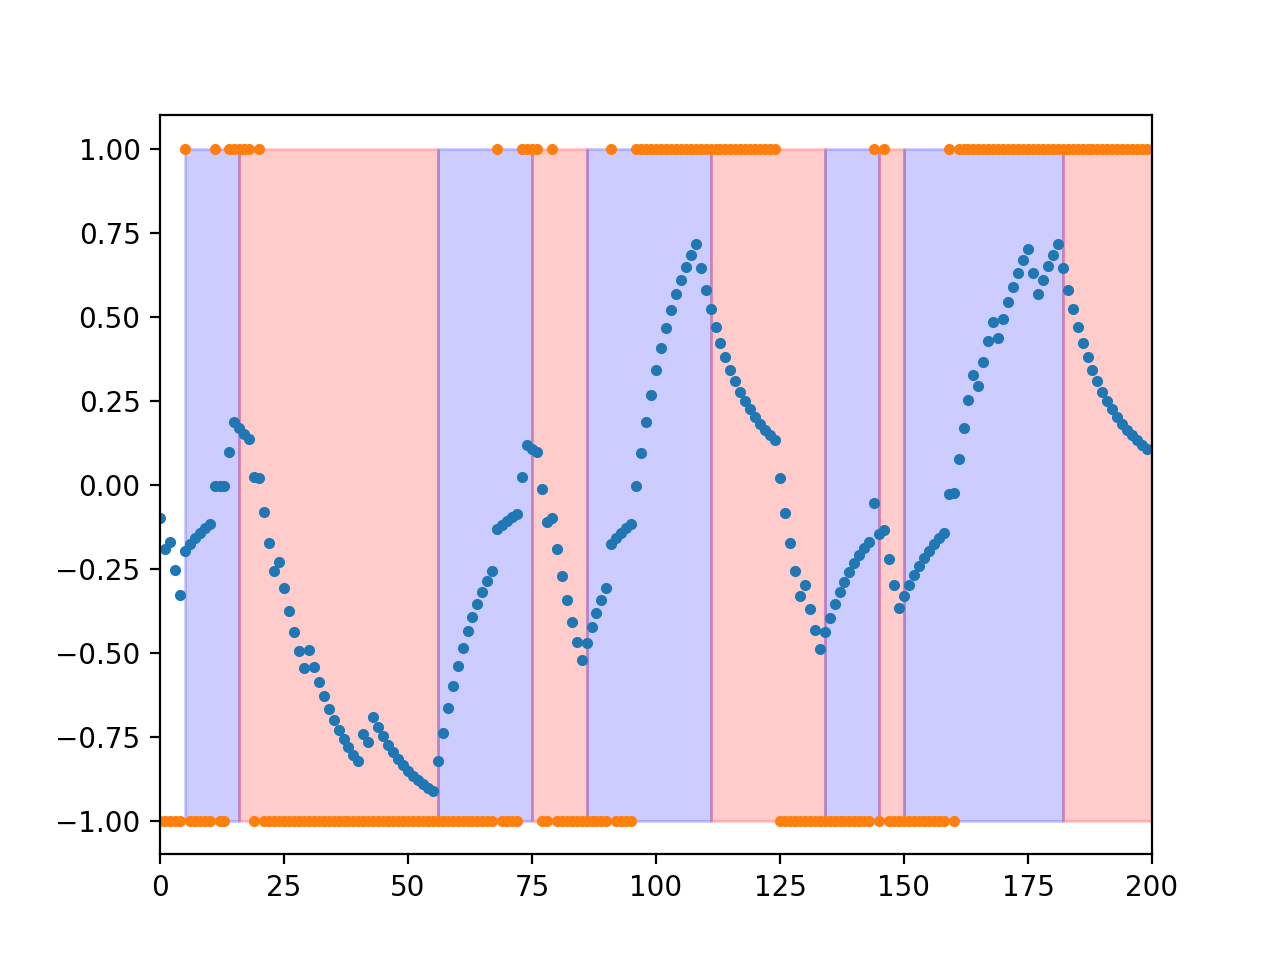

(0.0, 200.0)

In [4]:
plt.figure()
plt.plot(agent.find_prob()[:200], '.')
plt.plot(np.array(agent.choice_history[:200]) * 2 - 1, '.')

blockswitches = np.cumsum(world.ntrialblocks)
for i in range(len(world.ntrialblocks) - 1):
    if i % 2:
        plt.fill_between([blockswitches[i], blockswitches[i+1]], [-1,-1], [1, 1], color='r', alpha=0.2)
    else:
        plt.fill_between([blockswitches[i], blockswitches[i+1]], [-1,-1], [1, 1], color='b', alpha=0.2)
        
plt.xlim([0, 200])


<IPython.core.display.Javascript object>


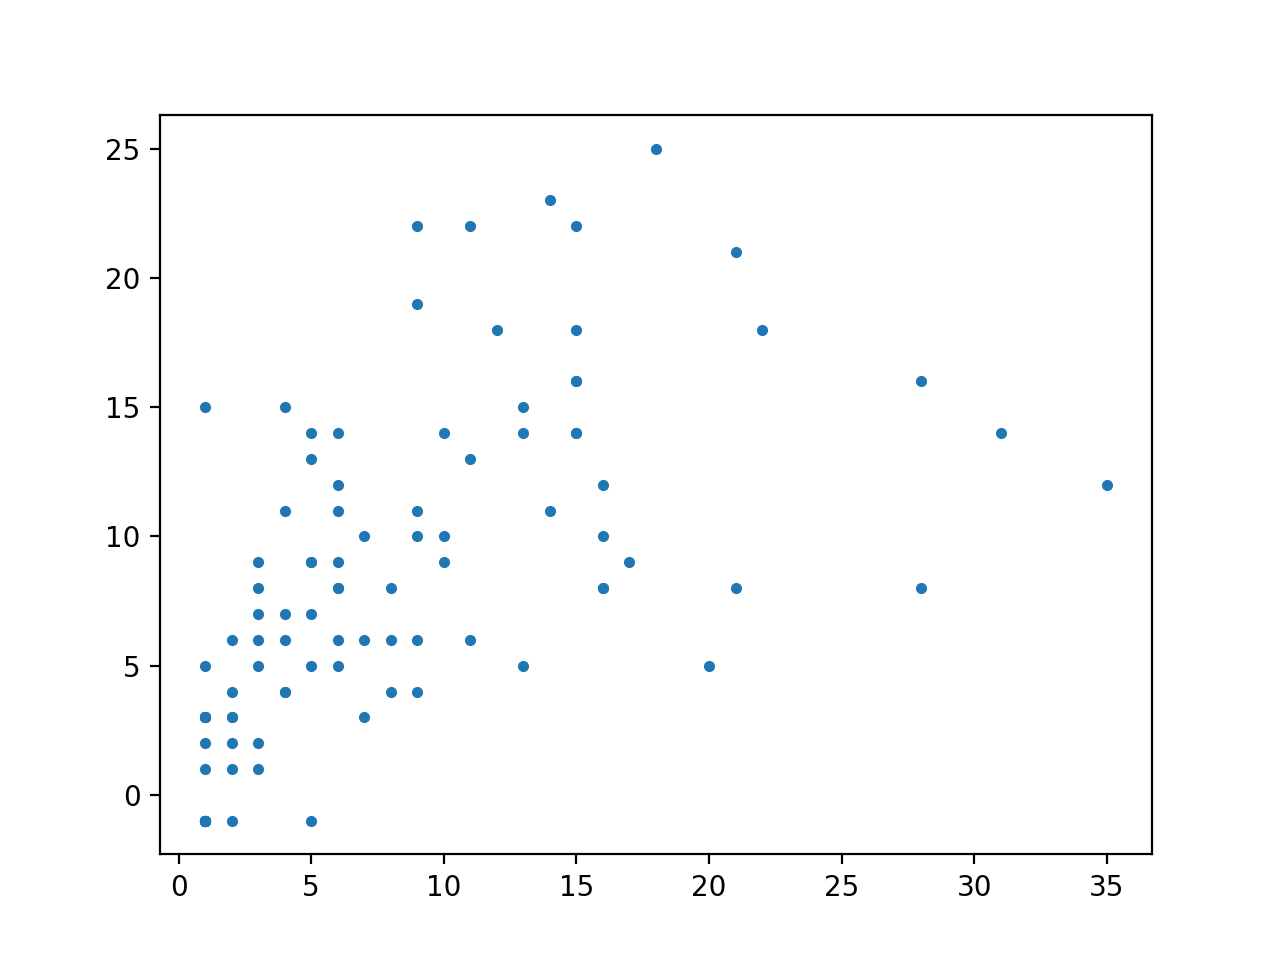

In [5]:
# Correlations based on number of rewards and errors (simple counting)
Nerrors = get_num_errors_leading_block(world, agent)
Nrews = get_num_rewards_trailing_block(world, agent)
# plt.plot(lst)
plt.figure()
plt.plot(Nrews[:-1], Nerrors[1:], '.')

skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping
skipping


<IPython.core.display.Javascript object>


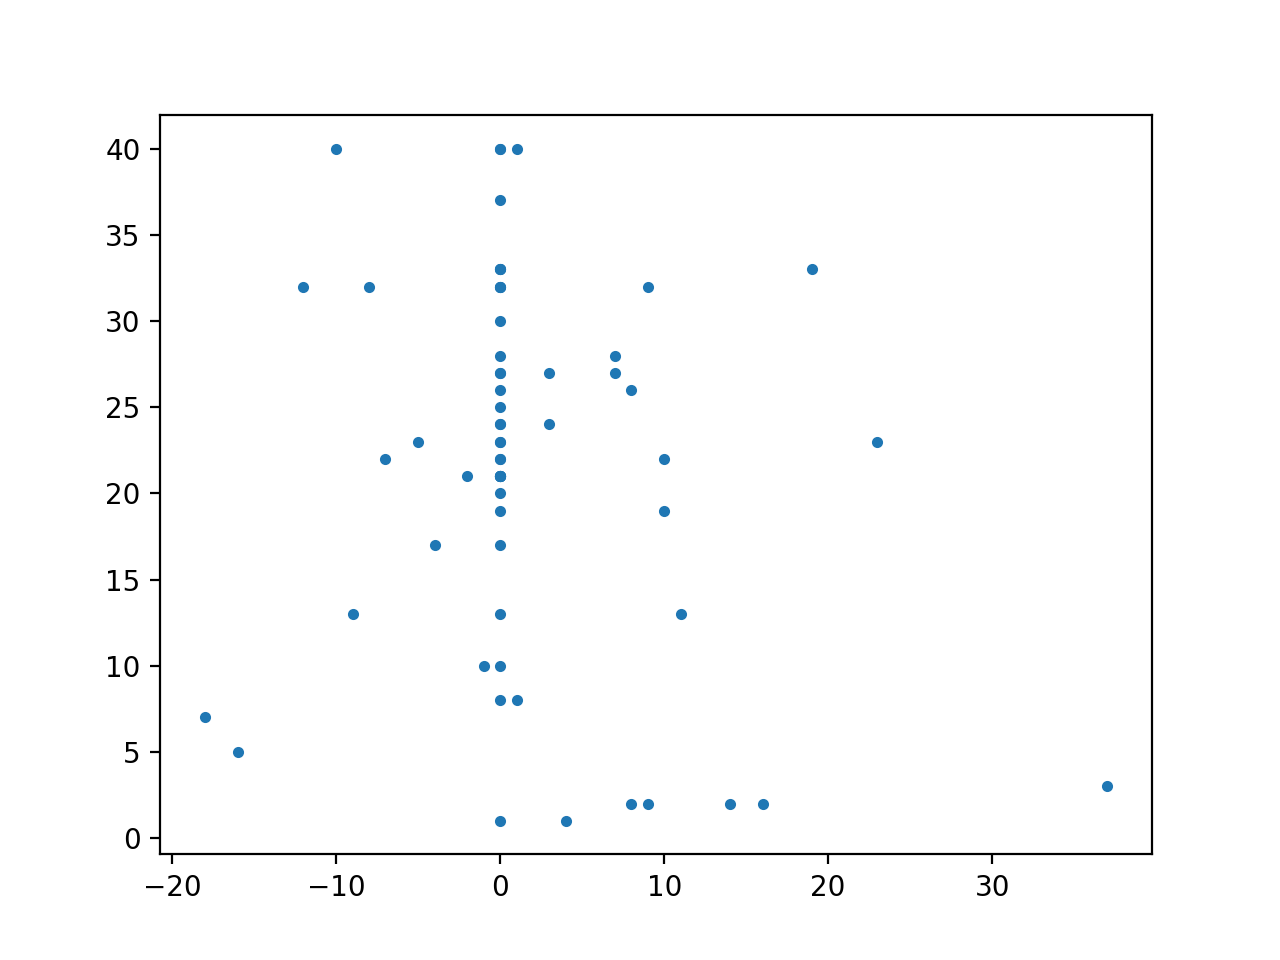

In [6]:
# Correlations based on hidden hmm fitting
lst = get_switch_times(world, agent).astype('float')
lst[lst == -1] = np.nan
nafterswitch = world.ntrialblocks[:-1] - lst
plt.figure()
plt.plot(nafterswitch[:-1], lst[1:], '.')

<IPython.core.display.Javascript object>


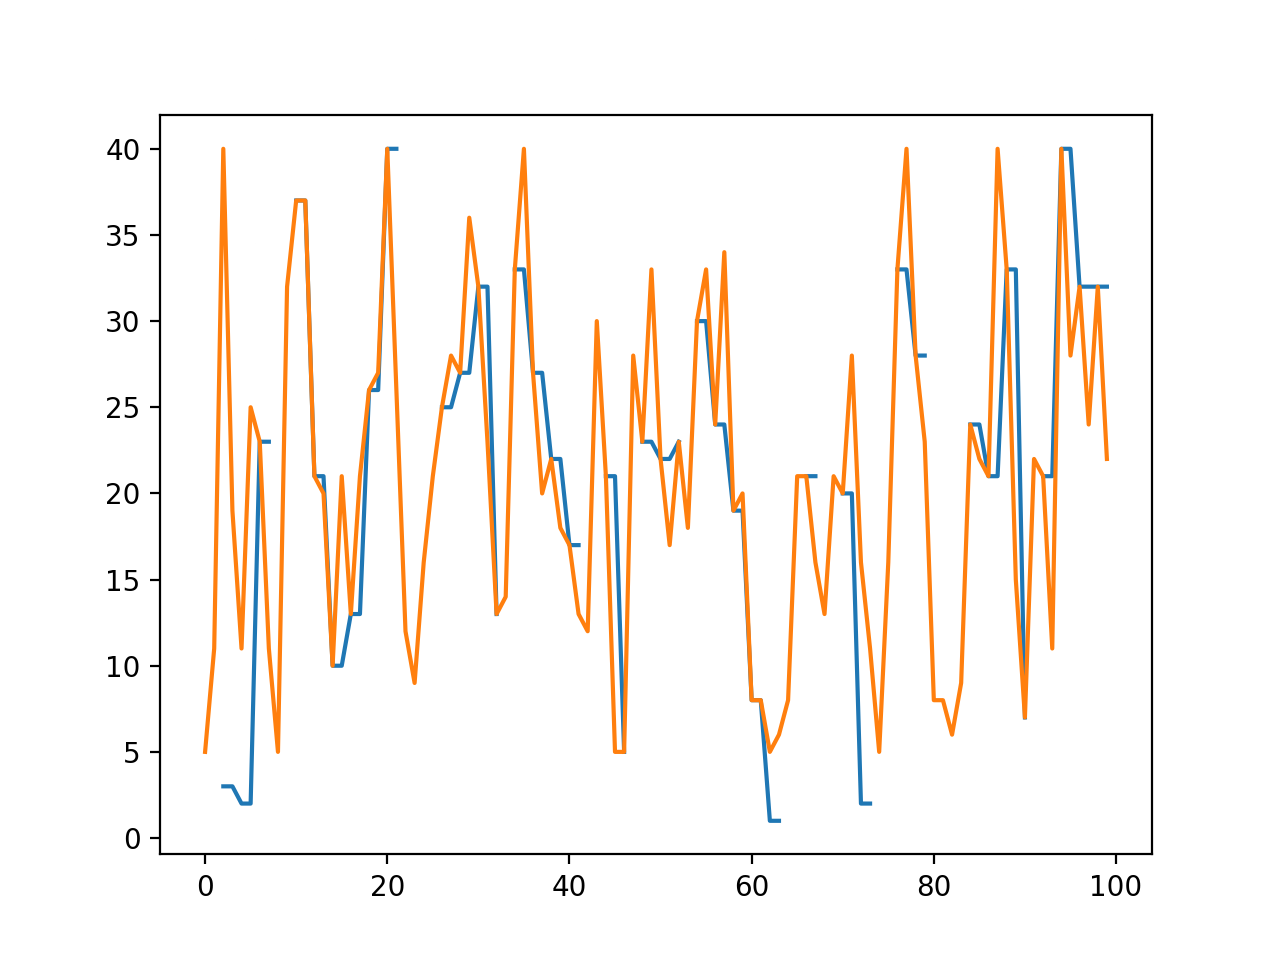

[]

In [7]:
plt.figure()
plt.plot(lst)
plt.plot(world.ntrialblocks[:-1])
plt.plot()

In [ ]:
lst